# Problem 9: Image classification with neural networks

First, we load in the required packages

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

Create a transform for a 80/20 train-test split

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [10]:
train_data = ImageFolder('imagedata', transform=transform)
test_data = ImageFolder('imagedata', transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

Define the neural net model class

In [11]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(16 * 112 * 112, num_classes)
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [12]:
model = CNN(num_classes=len(train_data.classes))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Run the epochs and train the net, takes ~2 hours

In [13]:
for epoch in range(10):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [14]:
model.eval()
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.numpy())
        all_preds.extend(preds.numpy())

In [15]:
accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
conf_matrix = confusion_matrix(all_labels, all_preds)

**Testing Accuracy and Confusion matrix**

In [16]:
print(f"Overall Test Set Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

Overall Test Set Accuracy: 0.73
Confusion Matrix:
[[1692   37   79  704   10   24  104  168   79  103]
 [   3 2219    2    0    0    9    0    0    0  767]
 [  18  125 1867  108   16  115  121  212   68  350]
 [  39   91   23 1873   21   20    8   82  244   99]
 [   0    0    0   22 2366    0    0  106    6    0]
 [ 130  283   14    9    1 1169    3    0   68  323]
 [  40   39  197  386   27   47 1324  288  117   35]
 [   1    3    9   56   15    3    8 2832   71    2]
 [  56  100    9  107   19   46    6   13 1809  335]
 [  20  198    5    1    7   83    1    0   18 2667]]


**Intepretating the results**

With 11 subdirectories, of approximately equal size, a baseline classifier would generate less than 10% accuracy. The Neural Net Accuracy was able to achieve 73% accuracy, a substantial improvement. The confusion matrixshows us that false positives were distrubted somewhat evenly over the different image classifications, indicating that there was no one image type that gave the model particular trouble. That being said, there are also several 0 coefficients in the confusion matrix, indicating that there are some image types the model never mistook for certain other image types.

**Images**

The nine images below are croppings of the compressed data that the neural net trained on. To the human eye, it is almost impossible to guess what these images represent. The neural net, though, was able to correctly classify 7/9 of the sample images below, roughly consistent with our expectation from the test accuracy figure. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


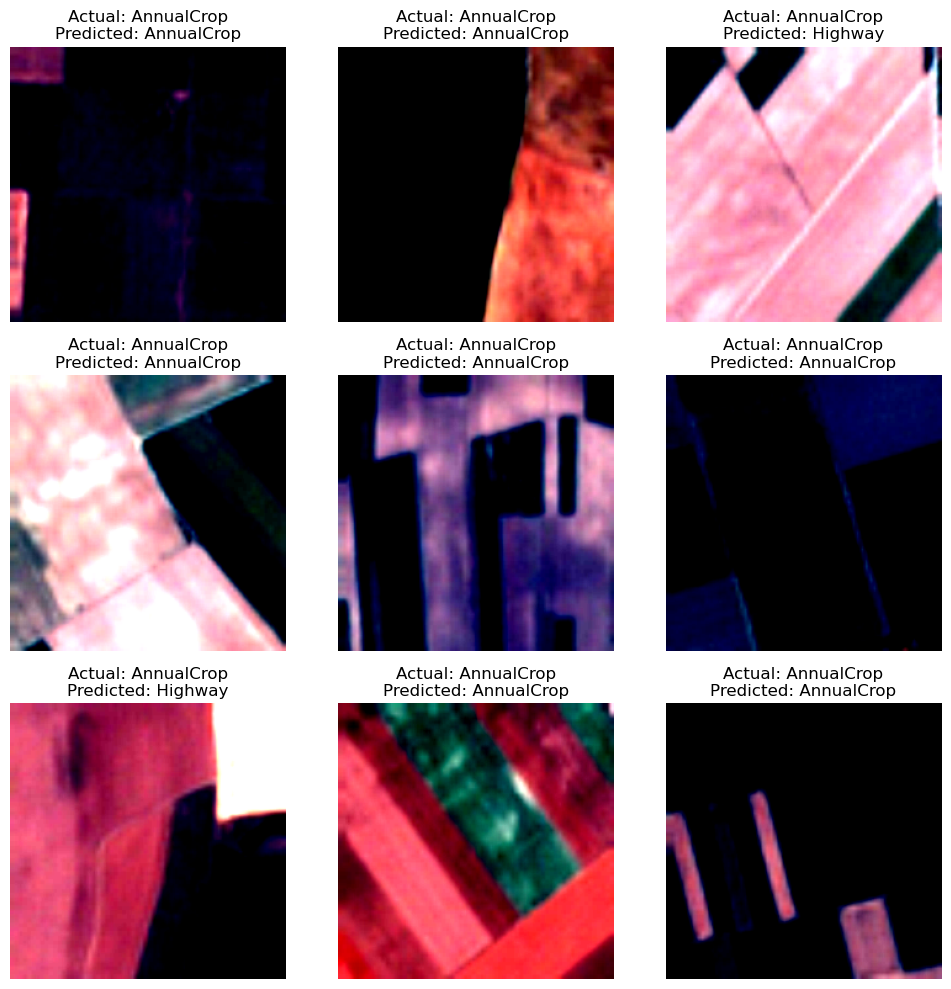

In [19]:
idx_to_class = {v: k for k, v in test_data.class_to_idx.items()}

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for ax, (img, label) in zip(axes.flatten(), test_data):
    with torch.no_grad():
        img = img.unsqueeze(0)  # Add batch dimension
        output = model(img)
        _, predicted_idx = torch.max(output, 1)
        predicted_class = idx_to_class[predicted_idx.item()]
    
    # Display image and predicted class
    ax.imshow(img.squeeze().permute(1, 2, 0))
    ax.set_title(f"Actual: {test_data.classes[label]}\nPredicted: {predicted_class}")
    ax.axis('off')

# Adjust layout and show plot
plt.tight_layout()
plt.show()